Initial explorations of calcium imaging data from V1DD dataset.
Same as `2025-08-29-explore-2p.ipynb`, but with helper functions factored out.

**Preliminary steps**
- Visualize population average activity over the whole session, across all volumes, to get a better handle of stimulus locking of responses.

**Sumary**
- Population average activity appears to be quite variable across stimuli and volumes.
- No obvious stimulus locking of activity spike.

From several conversations with Michael, Marina, Shuchen, and Saskia:
- Analyzing at the data acquisition resolution is too noisy, figure out how to do binning
- Every stimulus has slightly different characteristics and should be considered seperately
- Remember to focus on the final goal! Keep it simple!!

**Next steps**
- Saskia suggests to just focus on `drifting_gratings_full`, `spontaneous` and `natural_movies`
    - Bin responses (and behavioral variables) in 2s time bins corresponding to the `drifting_gratings_full` frame rate
    - Do the same binning for the other stimuli as well
    - _Don't_ do `drifting_gratings_windowed`; can't rule out the possibility of false negatives (i.e. a cell didn't respond simply because the stimulus wasn't aligned with its receptive field.) Don't run into this issue with `drifting_gratings_full` because the stimulus presentation is broader.
- Saskia suggests just focus on volumes 2 and 3 (the "good" volumes)
- Continuing testing out how to regress out behavior; definitely seems like a big factor
  - Standard scale the behavior variables (by stimulus epoch)
  - Use a GLM (but exactly what family?)
  - Minor: Time lagged behavioral variables (although binning should help!)

In [ ]:
%load_ext autoreload
%autoreload 2

# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
from funcky.utils import load_nwb_session, get_aligned_session_data

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

## Examine stimulus response for a single volume

In [3]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
session_data = get_aligned_session_data(nwb)

  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 516 NaNs detected; fillin in via interpolation.
  warnings.warn(


## Evaluate session responses

In [5]:
stim_epochs_df = nwb.epochs.to_dataframe()
stim_epochs_df

,stim_name,start_time,stop_time,duration
id,,,,
0,drifting_gratings_full,54.634430,341.856873,287.222443
1,drifting_gratings_windowed,344.876038,632.098572,287.222534
2,locally_sparse_noise,635.117737,875.334412,240.216675
3,spontaneous,876.318604,1176.552002,300.233398
4,natural_images_12,1179.571167,1331.681152,152.109985
5,natural_movie,1343.707764,1794.066162,450.358398
6,locally_sparse_noise,1798.119507,2098.236084,300.116577
7,natural_images,2100.337891,2399.503662,299.165771
8,drifting_gratings_windowed,2414.599609,2701.822021,287.222412


In [6]:
timestamps = session_data['timestamps']

# Get population avg and std
dff_avg = np.mean(session_data['dff_traces'], axis=0)
dff_std = np.std(session_data['dff_traces'], axis=0)

**Standard scale the behavior**

Behavioral variables seem to be very outlier before the first stimulus epoch and after the
last stimulus epoch. So let's fit the standard scaler to the behavioral data within these regions.

In [7]:
# Standard scale the behavior data
from sklearn.preprocessing import StandardScaler

start_index = np.argmin(np.abs(timestamps - stim_epochs_df['start_time'].min()))
stop_index = np.argmin(np.abs(timestamps - stim_epochs_df['stop_time'].max()))

behavior_traces = []
for traces in session_data['behavior_traces']:
    ss = StandardScaler().fit(traces[start_index:stop_index,None])
    behavior_traces.append(ss.transform(traces[:,None]).squeeze())

behavior_traces = np.array(behavior_traces)

behavior_names = session_data['behavior_names']

### Plot

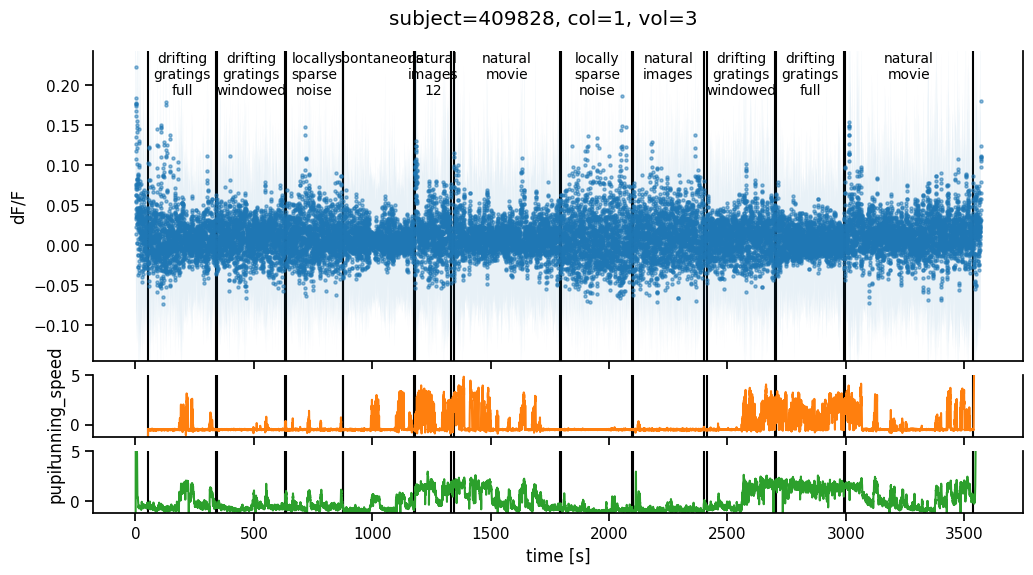

In [120]:
fig, axs = plt.subplots(
    nrows=3, height_ratios=[1,0.2,0.2], sharex=True,
    figsize=(12,6)
)
fig.subplots_adjust(hspace=0.1)

# -------------------------------------------------------------------------
# Row 1: Plot avg population trace
# -------------------------------------------------------------------------
ax = axs[0]
ax.scatter(timestamps, dff_avg, s=5, alpha=0.5, c='C0', label='df/F')
ax.fill_between(
    timestamps, dff_avg-dff_std, dff_avg+dff_std,
    color='C0', ec='none', alpha=0.1, zorder=1
)

ymin = np.percentile(dff_avg-dff_std, 1)
ymax = np.percentile(dff_avg+dff_std, 99)
ax.set_ylim(ymin,ymax)
ax.set_ylabel("dF/F")

# Add standard scaled behaviors
for i, (ax, name) in enumerate(zip(axs[1:], behavior_names)):
    ax.plot(timestamps, behavior_traces[i], color=f'C{i+1}')
    ax.set_ylabel(name)
    
    # ymin = np.percentile(behavior_traces[i], 2)
    # ymax = np.percentile(behavior_traces[i], 99)
    ymin, ymax = -1.25, 5
    ax.set_ylim(ymin,ymax)

# Plot stimulus epochs
for _, row in stim_epochs_df.iterrows():
    stim_name = row['stim_name']
    start_time = row['start_time']
    stop_time = row['stop_time']

    for ax in axs:
        ax.axvline(start_time, color='k', zorder=0)
        ax.axvline(stop_time, color='k', zorder=0)

        # Annotate
        if ax.get_subplotspec().is_first_row():
            xtext = 0.5*(stop_time-start_time) + start_time  # data coordinates
            ax.text(
                xtext, 1, '\n'.join(stim_name.split('_')), transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize='small'
            )

# make pretty
ax.set_xlabel("time [s]")
ax.margins(x=0.0)

fig.suptitle(
    f'subject={selected_session.subject_id.item()}, '
    + f'col={selected_session.column.item()}, '
    + f'vol={selected_session.volume.item()}',
    y=0.95
)

sns.despine(right=False)

## Do this for all volumes!

Time to twiddle your thumbs.

In [ ]:
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 223 NaNs detected; fillin in via interpolation.
  behavior_traces[nan_idxs] = np.interp(
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 408 NaNs detected; fillin in via interpolation.
  behavior_traces[nan_idxs] = np.interp(
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 516 NaNs detected; fillin in via interpolation.
  behavior_traces[nan_idxs] = np.interp(
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 465 NaNs detected; fillin in via interpolation.
  behavior_traces[nan_idxs] = np.interp(
/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/5 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:165: UserWarning: pupil: 131 NaNs detected; fillin in via interpolation.
  behavior_traces[nan_idxs] = np.interp(


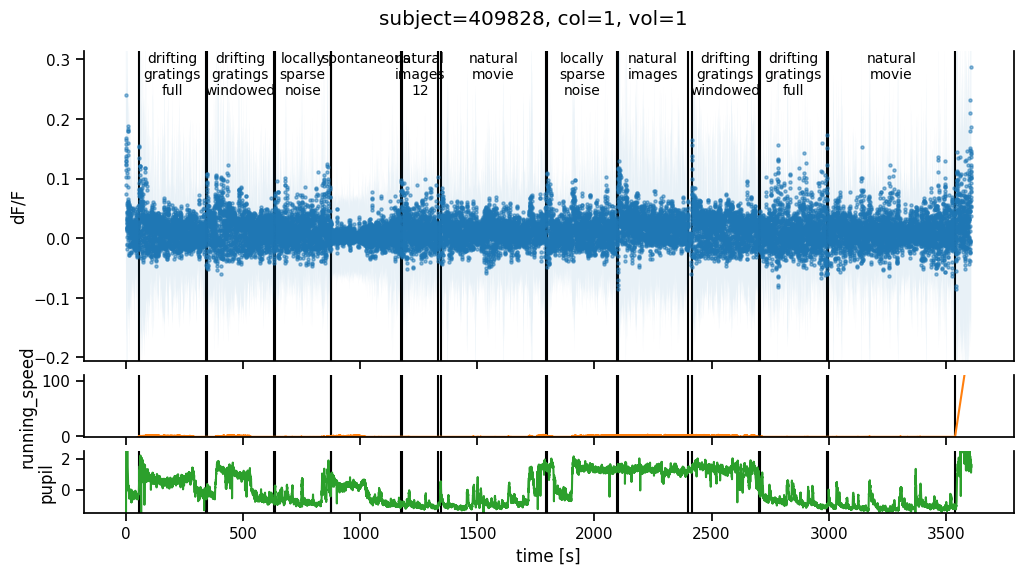

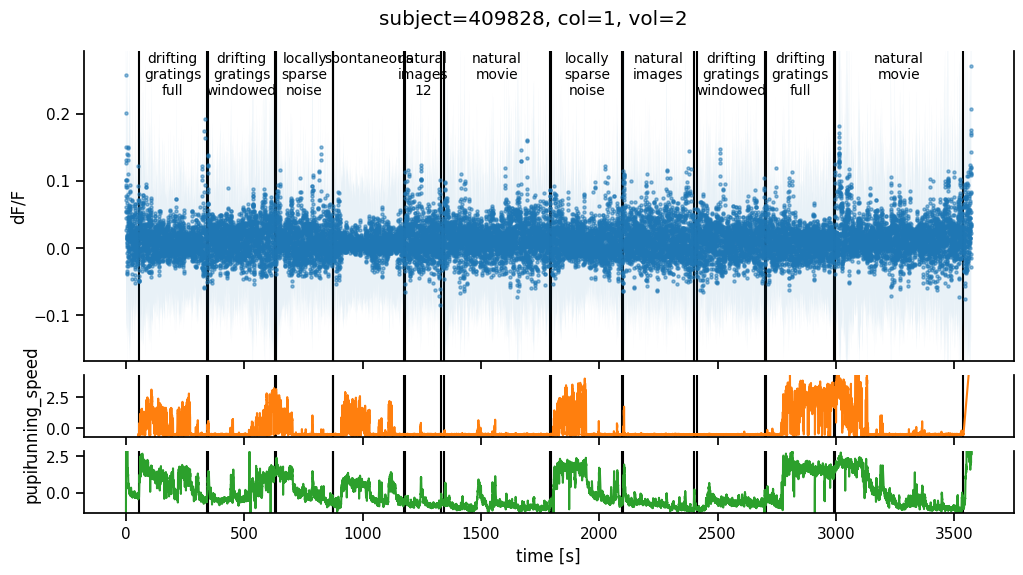

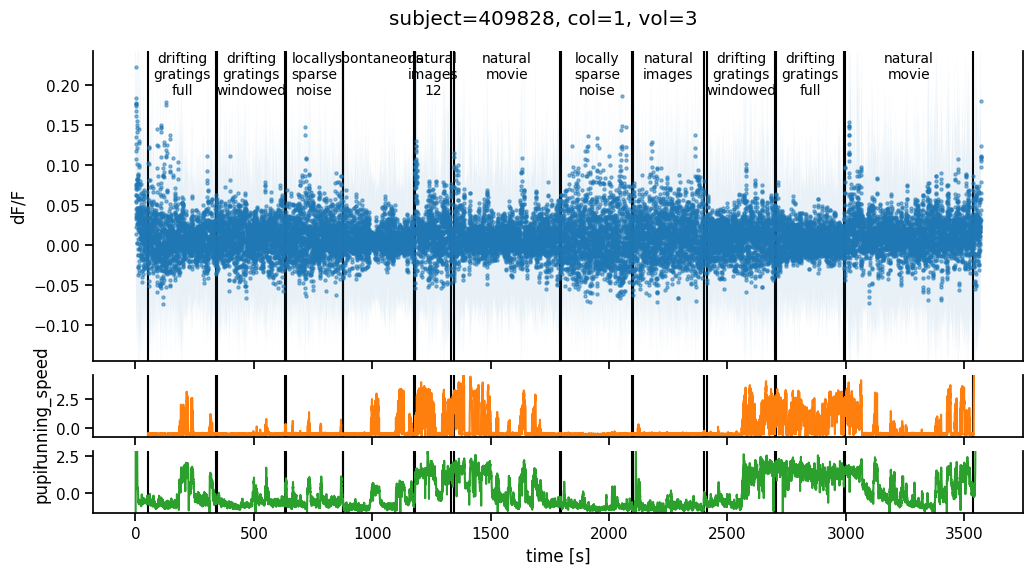

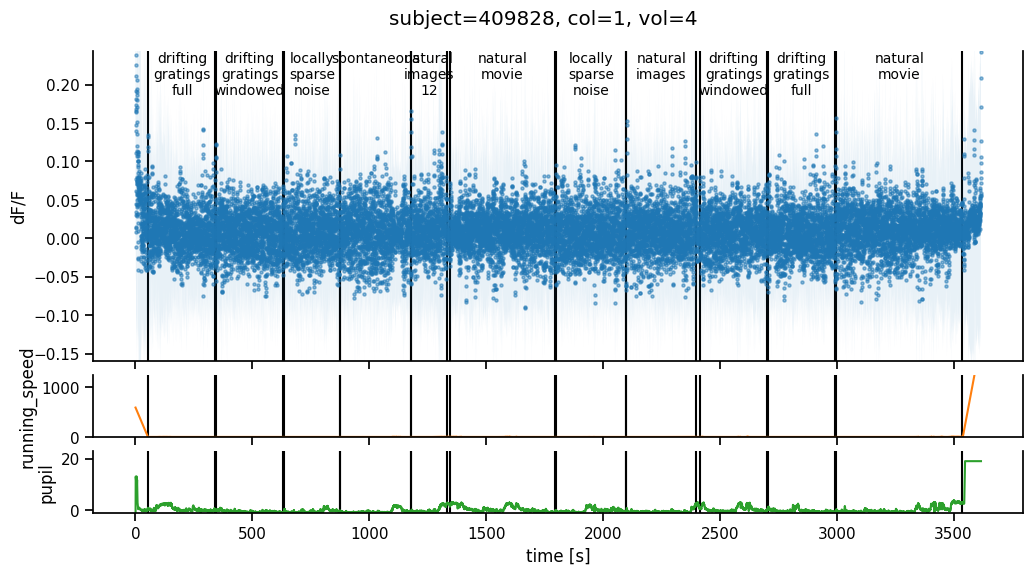

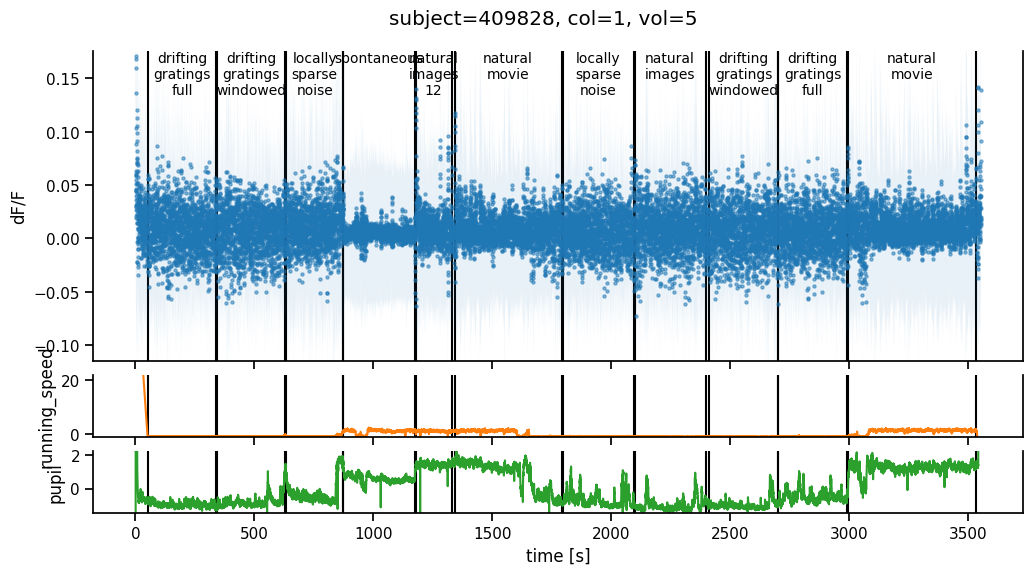

In [121]:
for volume in range(1, 6):
    selected_session = metadata[
        (metadata['golden_mouse']==True)    # mouse with structural info
        & (metadata['column']==1)           # center imaging column
        & (metadata['volume']==volume)           # not top or bottom volume
    ]

    # -------------------------------------------------------------------------
    # Load data
    # -------------------------------------------------------------------------
    nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)
    session_data = get_aligned_session_data(nwb)

    # Get stimulus epochs info
    stim_epochs_df = nwb.epochs.to_dataframe()

    # Get population avg and std
    timestamps = session_data['timestamps']
    dff_avg = np.mean(session_data['dff_traces'], axis=0)
    dff_std = np.std(session_data['dff_traces'], axis=0)

    # Perform standard scaling on the behavioral data
    behavior_names = session_data['behavior_names']

    start_index = np.argmin(np.abs(timestamps - stim_epochs_df['start_time'].min()))
    stop_index = np.argmin(np.abs(timestamps - stim_epochs_df['stop_time'].max()))

    behavior_traces = []
    for traces in session_data['behavior_traces']:
        ss = StandardScaler().fit(traces[start_index:stop_index,None])
        behavior_traces.append(ss.transform(traces[:,None]).squeeze())

    behavior_traces = np.array(behavior_traces)

    # -------------------------------------------------------------------------
    # Plot
    # -------------------------------------------------------------------------
    fig, axs = plt.subplots(
        nrows=3, height_ratios=[1,0.2,0.2], sharex=True,
        figsize=(12,6)
    )
    fig.subplots_adjust(hspace=0.1)
    
    # Row 1: Plot avg population trace ----------------------------------------
    ax = axs[0]
    ax.scatter(timestamps, dff_avg, s=5, alpha=0.5, c='C0', label='df/F')
    ax.fill_between(
        timestamps, dff_avg-dff_std, dff_avg+dff_std,
        color='C0', ec='none', alpha=0.1, zorder=1
    )

    ymin = np.percentile(dff_avg-dff_std, 1)
    ymax = np.percentile(dff_avg+dff_std, 99)
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel("dF/F")

    # Row 2-3: Plot standard scaled behaviors ---------------------------------
    for i, (ax, name) in enumerate(zip(axs[1:], behavior_names)):
        ax.plot(timestamps, behavior_traces[i], color=f'C{i+1}')
        ax.set_ylabel(name)
        
        ymin = np.percentile(behavior_traces[i], 2) * 1.2
        ymax = np.percentile(behavior_traces[i], 99) * 1.2
        ax.set_ylim(ymin,ymax)

    # All rows: Plot stimulus epochs ------------------------------------------
    for _, row in stim_epochs_df.iterrows():
        stim_name = row['stim_name']
        start_time = row['start_time']
        stop_time = row['stop_time']

        for ax in axs:
            ax.axvline(start_time, color='k', zorder=0)
            ax.axvline(stop_time, color='k', zorder=0)

            # Annotate
            if ax.get_subplotspec().is_first_row():
                xtext = 0.5*(stop_time-start_time) + start_time  # data coordinates
                ax.text(
                    xtext, 1, '\n'.join(stim_name.split('_')), transform=ax.get_xaxis_transform(),
                    ha='center', va='top', fontsize='small'
                )

    # make pretty
    ax.set_xlabel("time [s]")
    ax.margins(x=0.0)

    fig.suptitle(
        f'subject={selected_session.subject_id.item()}, '
        + f'col={selected_session.column.item()}, '
        + f'vol={selected_session.volume.item()}',
        y=0.95,
    )
    sns.despine(right=False)
    